In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, RidgeCV,LassoCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import time
from scipy.stats import mode
import warnings
from sklearn.exceptions import ConvergenceWarning

In [2]:
train = pd.read_csv('./data/X_train.csv')
test =  pd.read_csv('./data/X_test.csv')

In [3]:
def check_trajectories_start_zero(df, traj_len=257):
    num_traj = len(df) // traj_len
    zero_traj = []

    for i in range(num_traj):
        start_idx = i * traj_len
        first_row = df.iloc[start_idx]

        # Controlla se tutti i valori della prima riga sono zero
        if (first_row == 0).all():
            zero_traj.append(i)

    return zero_traj

In [4]:
train_no_id = train.iloc[:, :-1]
traj_zero=check_trajectories_start_zero(train_no_id,257)

In [5]:
def remove_zero_trajectories(df, zero_traj, traj_len=257):
    drop_indices = []

    for traj_id in zero_traj:
        start = traj_id * traj_len
        end = (traj_id + 1) * traj_len
        drop_indices.extend(range(start, end))

    df_cleaned = df.drop(drop_indices).reset_index(drop=True)
    return df_cleaned

In [6]:
train_cleaned = remove_zero_trajectories(train, traj_zero, 257)


In [7]:
def remove_collision(df, traj_len=257, tol=1e-8):

    cleaned = []
    num_traj = len(df) // traj_len

    for i in range(num_traj):
        start = i * traj_len
        end = (i + 1) * traj_len
        traj = df.iloc[start:end]

        traj_features = traj.iloc[:, :-1]

        zero_mask = (np.abs(traj_features.values) < tol).all(axis=1)

        if zero_mask.any():
            first_zero = zero_mask.argmax() + start
            traj = traj.loc[start:first_zero-1]

        cleaned.append(traj)

    cleaned_df = pd.concat(cleaned).reset_index(drop=True)
    return cleaned_df

In [8]:
train_cleaned = remove_collision(train_cleaned)

In [9]:
def train_validation_split(df, train_size=0.6, 
                                validation_size=0.2, 
                                test_size=0.2, 
                                method="random", 
                                random_state=None):

    if random_state is not None:
        np.random.seed(random_state)

    # Identifier les indices de début de trajectoire
    traj_start_indices = df.index[df['t'] == 0].tolist()
    traj_start_indices.append(len(df))  # ajouter la fin pour le dernier bloc

    # Construire les slices de trajectoires
    traj_slices = [(traj_start_indices[i], traj_start_indices[i+1]) for i in range(len(traj_start_indices)-1)]
    
    if method == "random":
        np.random.shuffle(traj_slices)
    else:
        raise NotImplementedError(f"Méthode {method} non implémentée pour l'instant")

    n_traj = len(traj_slices)
    n_train = int(train_size * n_traj)
    n_val = int(validation_size * n_traj)
    n_test = int(test_size * n_traj)

    # Ajustement si reste
    n_remaining = n_traj - (n_train + n_val + n_test)
    n_train += n_remaining

    train_slices = traj_slices[:n_train]
    val_slices = traj_slices[n_train:n_train+n_val]
    test_slices = traj_slices[n_train+n_val:n_train+n_val+n_test]

    # Concaténer les DataFrames correspondants
    train_df = pd.concat([df.iloc[start:end] for start, end in train_slices])
    val_df = pd.concat([df.iloc[start:end] for start, end in val_slices])
    test_df = pd.concat([df.iloc[start:end] for start, end in test_slices])

    return train_df, val_df, test_df

In [10]:
def replicate_initial_position_by_block(df):
    coords = ["x_1", "y_1",
              "x_2", "y_2",
              "x_3", "y_3"]

    copy = df.copy()
    data = copy[coords].values
    t_values = copy["t"].values

    # Détecter le début des blocs
    block_starts = np.where(t_values == 0)[0]
    block_starts = np.append(block_starts, len(df))  # ajouter fin du dernier bloc

    # Répliquer la position initiale pour chaque bloc
    for i in range(len(block_starts) - 1):
        start, end = block_starts[i], block_starts[i + 1]
        data[start:end] = data[start]  # réplication vectorisée

        # Dernière ligne : ne copier que si t == 10
        last_idx = end - 1
        if t_values[last_idx] != 10:
            data[last_idx] = copy.iloc[last_idx][coords].values

    copy[coords] = data
    return copy

In [11]:
def validate_poly_regression_v2( X_train,  y_train,  X_val, y_val, regressor=None,degrees= range(1, 9)) :
    """
    Validation of polynomial regression models with different degrees.
    """

    best_rmse = float('inf')
    best_degree = 0
    best_pipeline = None
    rmse_values = []

    # Use Linear Regression as default regressor if none provided
    if regressor is None:
        base_regressor = LinearRegression()

    elif regressor is RidgeCV:
        # Instanciez RidgeCV avec des hyperparamètres pour la validation croisée interne
        base_regressor = RidgeCV(
            alphas=np.logspace(-6, 3, 10),
            scoring='neg_mean_squared_error',
            cv=5
        )

    # -Iterate over each degree
    for degree in degrees:

        # 1. Define the pipeline
        pipeline = Pipeline([
            ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
            ('scaler', StandardScaler()),
            ('regressor', base_regressor)
        ])

        # 2. Train the model
        pipeline.fit(X_train, y_train)

        # Print the number of features
        n_features = pipeline['poly'].n_output_features_
        print(f"Degree: {degree}, Number of features: {n_features}")

        # 3 Predict on validation set
        y_val_pred = pipeline.predict(X_val)

        # 4. Evaluate the model
        rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        rmse_values.append((degree, rmse))

        # 5. Save the best model
        if rmse < best_rmse:
            best_rmse = rmse
            best_degree = degree
            best_pipeline = pipeline

    print(f"\nBest Degree: {best_degree} with RMSE: {best_rmse:.4f}")
    return best_rmse,best_degree



In [13]:

# --- CONFIGURATION ---
NUM_TRAJECTORIES_TO_SAMPLE = 50 
# The first line is implicitly the start of the first trajectory (index 0)
start_indices = train_cleaned[train_cleaned['t'] == 0].index.tolist()
end_indices = start_indices[1:] + [len(train_cleaned)]

# Create the list of (start_index, end_index) tuples
trajectory_limits = list(zip(start_indices, end_indices))

total_trajectories_available_cleaned = len(trajectory_limits)

# --- STEP 2: FIXED RANDOM SAMPLING ---
random_trajectory_indices = np.random.choice(
    total_trajectories_available_cleaned,
    size=NUM_TRAJECTORIES_TO_SAMPLE,
    replace=False
)

# Create the master list of row indices (sample_rows) from the limits
sample_rows = []
for traj_id in random_trajectory_indices:
    start, end = trajectory_limits[traj_id]
    sample_rows.extend(range(start, end))

# Extract the final fixed raw DataFrame sample
sampled_data_fixed = train_cleaned.iloc[sample_rows].reset_index(drop=True)


--- Run 1/15 ---
Degree: 1, Number of features: 7
Degree: 2, Number of features: 35
Degree: 3, Number of features: 119
Degree: 4, Number of features: 329
Degree: 5, Number of features: 791
Degree: 6, Number of features: 1715
Degree: 7, Number of features: 3431
Degree: 8, Number of features: 6434

Best Degree: 1 with RMSE: 0.9982

--- Run 2/15 ---
Degree: 1, Number of features: 7
Degree: 2, Number of features: 35
Degree: 3, Number of features: 119
Degree: 4, Number of features: 329
Degree: 5, Number of features: 791
Degree: 6, Number of features: 1715
Degree: 7, Number of features: 3431
Degree: 8, Number of features: 6434

Best Degree: 2 with RMSE: 0.8408

--- Run 3/15 ---
Degree: 1, Number of features: 7
Degree: 2, Number of features: 35
Degree: 3, Number of features: 119
Degree: 4, Number of features: 329
Degree: 5, Number of features: 791
Degree: 6, Number of features: 1715
Degree: 7, Number of features: 3431
Degree: 8, Number of features: 6434

Best Degree: 1 with RMSE: 1.3281

---

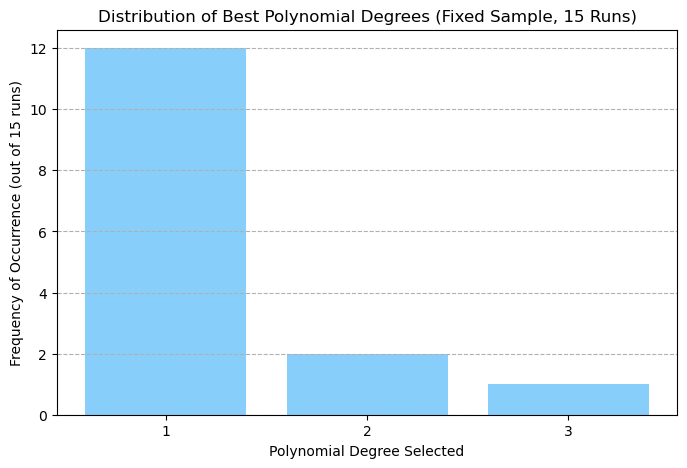

Frequency of each degree:
  Degree 1: 12 times
  Degree 2: 2 times
  Degree 3: 1 times

--- Comparison of Top 2 Most Frequent Degrees ---
Degree 1: selected 12 times, Average RMSE: 1.1785
Degree 2: selected 2 times, Average RMSE: 1.0190
✓ Degree 2 selected for having LOWER RMSE


In [14]:

# --- STEP 2: ITERATION LOOP (Splitting & Preprocessing Inside) ---
NUM_RUNS=15
best_result=[]
for i in range(NUM_RUNS):
    # 1. DYNAMIC SPLIT (Source of Variability: The split changes every run)
    # This must use the fixed raw sample: sampled_data_fixed
    train_data_raw, val_data_raw, _ = train_validation_split(sampled_data_fixed)
    
    # 2. TRANSFORMATION (Post-Split Preprocessing)
    
    # Training Data Processing
    train_entry_processed = replicate_initial_position_by_block(train_data_raw)
    X_train_sampled = train_entry_processed[["t", "x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]].values
    Y_train_sampled = train_data_raw[["x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]].values

    # Validation Data Processing
    val_entry_processed = replicate_initial_position_by_block(val_data_raw)
    X_val_sampled = val_entry_processed[["t", "x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]].values
    Y_val_sampled = val_data_raw[["x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]].values
    

    # 3. FUNCTION CALL
    print(f"\n--- Run {i+1}/{NUM_RUNS} ---")
    best_rmse, best_degree = validate_poly_regression_v2(
        X_train_sampled,
        Y_train_sampled,
        X_val_sampled,
        Y_val_sampled
    )

    best_result.append((best_degree, best_rmse))


# --- STEP 3: FINAL ANALYSIS AND PLOT ---

best_degrees_distribution = [res[0] for res in best_result]
counts = np.bincount(best_degrees_distribution)
degrees = np.arange(len(counts))

# 1. Plotting the distribution
plt.figure(figsize=(8, 5))
plt.bar(degrees[1:], counts[1:], color='lightskyblue') 
plt.xlabel('Polynomial Degree Selected')
plt.ylabel(f"Frequency of Occurrence (out of {NUM_RUNS} runs)")
plt.xticks(degrees[1:])
plt.grid(axis='y', linestyle='--')
plt.title(f"Distribution of Best Polynomial Degrees (Fixed Sample, {NUM_RUNS} Runs)")
plt.show() 

# 1. Convert the list of results into a DataFrame for easier filtering
results_df = pd.DataFrame(best_result, columns=['Degree', 'RMSE'])

# 2. Find the two most frequent degrees
degree_counts = results_df['Degree'].value_counts()
print("Frequency of each degree:")
for degree, count in degree_counts.items():
    print(f"  Degree {degree}: {count} times")

# Get the two most frequent degrees
top_degrees = degree_counts.head(2).index.tolist()

if len(top_degrees) == 1:
    # Only one degree appeared
    best_selected_degree = top_degrees[0]
    average_rmse = results_df[results_df['Degree'] == best_selected_degree]['RMSE'].mean()
    print(f"\n--- Final Analysis ---")
    print(f"Only one degree selected across all runs: {best_selected_degree}")
    print(f"Average RMSE: {average_rmse:.4f}")
    
else:
    # Compare the two most frequent degrees
    degree1, degree2 = top_degrees
    rmse_degree1 = results_df[results_df['Degree'] == degree1]['RMSE']
    rmse_degree2 = results_df[results_df['Degree'] == degree2]['RMSE']
    
    avg_rmse_degree1 = rmse_degree1.mean()
    avg_rmse_degree2 = rmse_degree2.mean()
    
    print(f"\n--- Comparison of Top 2 Most Frequent Degrees ---")
    print(f"Degree {degree1}: selected {len(rmse_degree1)} times, Average RMSE: {avg_rmse_degree1:.4f}")
    print(f"Degree {degree2}: selected {len(rmse_degree2)} times, Average RMSE: {avg_rmse_degree2:.4f}")
    
    # Select the degree with the lowest average RMSE
    if avg_rmse_degree1 < avg_rmse_degree2:
        best_selected_degree = degree1
        best_avg_rmse = avg_rmse_degree1
        print(f"✓ Degree {degree1} selected for having LOWER RMSE")
    else:
        best_selected_degree = degree2
        best_avg_rmse = avg_rmse_degree2
        print(f"✓ Degree {degree2} selected for having LOWER RMSE")


--- Run 1/15 ---
Degree: 1, Number of features: 7
Degree: 2, Number of features: 35
Degree: 3, Number of features: 119
Degree: 4, Number of features: 329
Degree: 5, Number of features: 791
Degree: 6, Number of features: 1715
Degree: 7, Number of features: 3431
Degree: 8, Number of features: 6434

Best Degree: 2 with RMSE: 1.5150

--- Run 2/15 ---
Degree: 1, Number of features: 7
Degree: 2, Number of features: 35
Degree: 3, Number of features: 119
Degree: 4, Number of features: 329
Degree: 5, Number of features: 791
Degree: 6, Number of features: 1715
Degree: 7, Number of features: 3431
Degree: 8, Number of features: 6434

Best Degree: 2 with RMSE: 1.1010

--- Run 3/15 ---
Degree: 1, Number of features: 7
Degree: 2, Number of features: 35
Degree: 3, Number of features: 119
Degree: 4, Number of features: 329
Degree: 5, Number of features: 791
Degree: 6, Number of features: 1715
Degree: 7, Number of features: 3431
Degree: 8, Number of features: 6434

Best Degree: 2 with RMSE: 0.9702

---

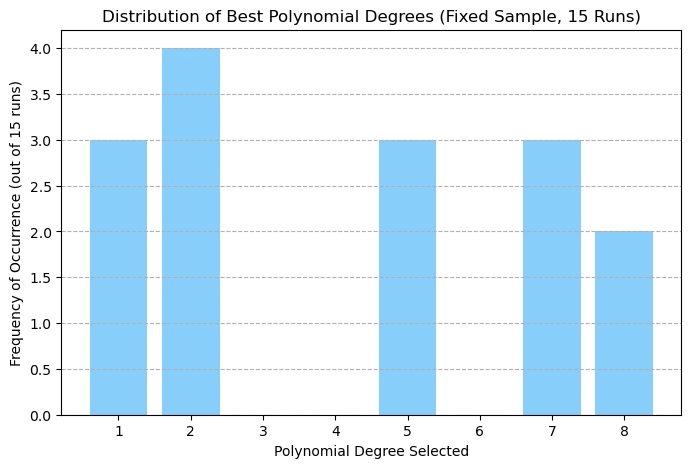

Frequency of each degree:
  Degree 2: 4 times
  Degree 7: 3 times
  Degree 5: 3 times
  Degree 1: 3 times
  Degree 8: 2 times

--- Comparison of Top 2 Most Frequent Degrees ---
Degree 2: selected 4 times, Average RMSE: 1.1923
Degree 7: selected 3 times, Average RMSE: 1.2952
✓ Degree 2 selected for having LOWER RMSE


In [15]:
NUM_RUNS=15
best_result=[]
for i in range(NUM_RUNS):
    # 1. DYNAMIC SPLIT (Source of Variability: The split changes every run)
    # This must use the fixed raw sample: sampled_data_fixed
    train_data_raw, val_data_raw, _ = train_validation_split(sampled_data_fixed)
    
    # 2. TRANSFORMATION (Post-Split Preprocessing)
    
    # Training Data Processing
    train_entry_processed = replicate_initial_position_by_block(train_data_raw)
    X_train_sampled = train_entry_processed[["t", "x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]].values
    Y_train_sampled = train_data_raw[["x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]].values

    # Validation Data Processing
    val_entry_processed = replicate_initial_position_by_block(val_data_raw)
    X_val_sampled = val_entry_processed[["t", "x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]].values
    Y_val_sampled = val_data_raw[["x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]].values

    # 3. FUNCTION CALL
    print(f"\n--- Run {i+1}/{NUM_RUNS} ---")
    best_rmse, best_degree = validate_poly_regression_v2(
        X_train_sampled,
        Y_train_sampled,
        X_val_sampled,
        Y_val_sampled,
        RidgeCV
    )

    best_result.append((best_degree, best_rmse))


# --- STEP 3: FINAL ANALYSIS AND PLOT ---

best_degrees_distribution = [res[0] for res in best_result]
counts = np.bincount(best_degrees_distribution)
degrees = np.arange(len(counts))

# 1. Plotting the distribution
plt.figure(figsize=(8, 5))
plt.bar(degrees[1:], counts[1:], color='lightskyblue') 
plt.xlabel('Polynomial Degree Selected')
plt.ylabel(f"Frequency of Occurrence (out of {NUM_RUNS} runs)")
plt.xticks(degrees[1:])
plt.grid(axis='y', linestyle='--')
plt.title(f"Distribution of Best Polynomial Degrees (Fixed Sample, {NUM_RUNS} Runs)")
plt.show() 

# 1. Convert the list of results into a DataFrame for easier filtering
results_df = pd.DataFrame(best_result, columns=['Degree', 'RMSE'])

# 2. Find the two most frequent degrees
degree_counts = results_df['Degree'].value_counts()
print("Frequency of each degree:")
for degree, count in degree_counts.items():
    print(f"  Degree {degree}: {count} times")

# Get the two most frequent degrees
top_degrees = degree_counts.head(2).index.tolist()

if len(top_degrees) == 1:
    # Only one degree appeared
    best_selected_degree = top_degrees[0]
    average_rmse = results_df[results_df['Degree'] == best_selected_degree]['RMSE'].mean()
    print(f"\n--- Final Analysis ---")
    print(f"Only one degree selected across all runs: {best_selected_degree}")
    print(f"Average RMSE: {average_rmse:.4f}")
    
else:
    # Compare the two most frequent degrees
    degree1, degree2 = top_degrees
    rmse_degree1 = results_df[results_df['Degree'] == degree1]['RMSE']
    rmse_degree2 = results_df[results_df['Degree'] == degree2]['RMSE']
    
    avg_rmse_degree1 = rmse_degree1.mean()
    avg_rmse_degree2 = rmse_degree2.mean()
    
    print(f"\n--- Comparison of Top 2 Most Frequent Degrees ---")
    print(f"Degree {degree1}: selected {len(rmse_degree1)} times, Average RMSE: {avg_rmse_degree1:.4f}")
    print(f"Degree {degree2}: selected {len(rmse_degree2)} times, Average RMSE: {avg_rmse_degree2:.4f}")
    
    # Select the degree with the lowest average RMSE
    if avg_rmse_degree1 < avg_rmse_degree2:
        best_selected_degree = degree1
        best_avg_rmse = avg_rmse_degree1
        print(f"✓ Degree {degree1} selected for having LOWER RMSE")
    else:
        best_selected_degree = degree2
        best_avg_rmse = avg_rmse_degree2
        print(f"✓ Degree {degree2} selected for having LOWER RMSE")

In [19]:
train,val,test_split=train_validation_split(train_cleaned)
train_entry = replicate_initial_position_by_block(train)
val_entry = replicate_initial_position_by_block(val)
test_entry = replicate_initial_position_by_block(test_split)
input_cols = ['t', 'x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']
target_cols = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']

In [17]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning) 

warnings.filterwarnings("ignore", "Ill-conditioned matrix", module="scipy.linalg")
FINAL_BEST_DEGREE=2
base_regressor = RidgeCV(
    alphas=np.logspace(-3, 1, 10),
    scoring='neg_mean_squared_error',
    cv=5 # 5-fold Cross-Validation pour déterminer l'alpha optimal
)
X_final_train = train_entry[input_cols]
# Y includes the target positions (the original, unshifted coordinates)
Y_final_train = train[target_cols]
# The pipeline defines the exact sequence of transformations required for the final model.
final_pipeline = Pipeline([
    # 2. Scaling: Standardizes data 
    ('scaler', StandardScaler()),
    # 1. Polynomial Features: Generates interactions up to the optimal degree (5)
    ('poly', PolynomialFeatures(degree=FINAL_BEST_DEGREE, include_bias=False)),

    # 3. Ridge Regression: Uses internal Cross-Validation (CV) to find the best alpha
    # on the full training set, maximizing generalization.
    ('regressor', base_regressor)
])
# --- FINAL MODEL TRAINING ---
print(f"\nTraining the final model...")
final_pipeline.fit(X_final_train, Y_final_train)


Training the final model...


Pipeline(steps=[('scaler', StandardScaler()),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('regressor',
                 RidgeCV(alphas=array([1.00000000e-03, 2.78255940e-03, 7.74263683e-03, 2.15443469e-02,
       5.99484250e-02, 1.66810054e-01, 4.64158883e-01, 1.29154967e+00,
       3.59381366e+00, 1.00000000e+01]),
                         cv=5, scoring='neg_mean_squared_error'))])

In [20]:
X_val = val_entry[input_cols]
y_val = val[target_cols]

y_pred_val = final_pipeline.predict(X_val)

X_test = test_entry[input_cols]
y_test= test_split[target_cols]
y_pred_test = final_pipeline.predict(X_test)
rmse_validation = np.sqrt(mean_squared_error(y_val,y_pred_val))
print("RMSE validation:", rmse_validation)

rmse_test =np.sqrt(mean_squared_error (y_test,y_pred_test))
print("RMSE test :", rmse_test)

RMSE validation: 1.4050720716648422
RMSE test : 1.3594180189300402


In [107]:
def plot_y_yhat(y_test,y_pred, plot_title = "plot"):
    labels = ['x_1','y_1','x_2','y_2','x_3','y_3']
    MAX = 500
    if len(y_test) > MAX:
        idx = np.random.choice(len(y_test),MAX, replace=False)
    else:
        idx = np.arange(len(y_test))
    plt.figure(figsize=(10,10))
    for i in range(6):
        x0 = np.min(y_test[idx,i])
        x1 = np.max(y_test[idx,i])
        plt.subplot(3,2,i+1)
        plt.scatter(y_test[idx,i],y_pred[idx,i])
        plt.xlabel('True '+labels[i])
        plt.ylabel('Predicted '+labels[i])
        plt.plot([x0,x1],[x0,x1],color='red')
        plt.axis('square')
    plt.show()

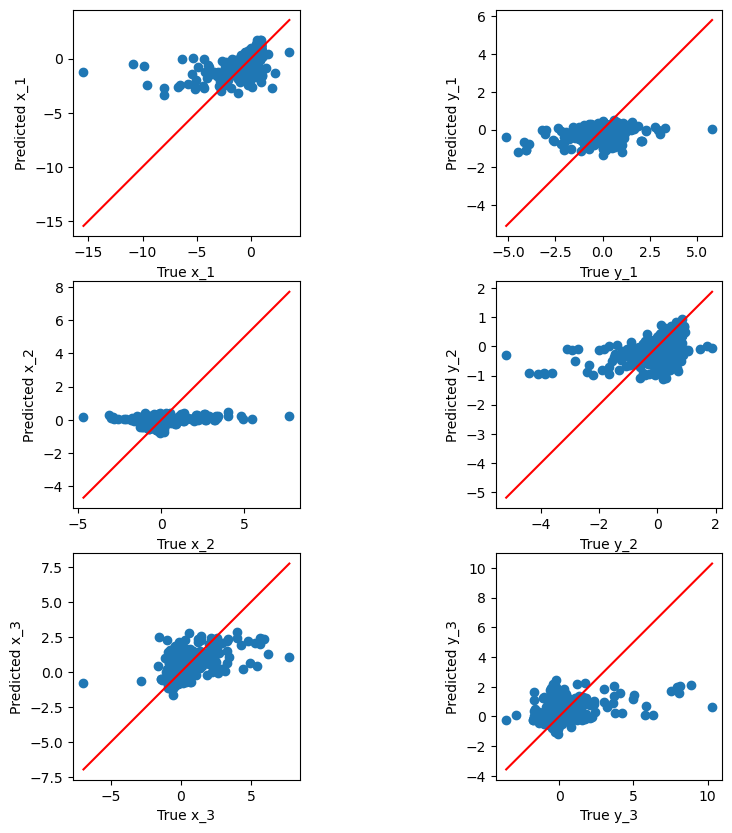

In [108]:
plot_y_yhat(y_test.values, y_pred_test, plot_title="plot")

In [102]:
X_test = test[['t','x0_1','y0_1','x0_2','y0_2','x0_3','y0_3']].copy()
X_test.columns = ['t','x_1','y_1','x_2','y_2','x_3','y_3'] 
ids = test['Id']

# Faire les prédictions
predictions = final_pipeline.predict(X_test)

# Créer le CSV de sortie
target_cols = ['x_1','y_1','x_2','y_2','x_3','y_3']
output_df = pd.DataFrame(predictions, columns=target_cols)
output_df.insert(0, 'Id', ids)
output_df.to_csv('polynomial_submission.csv', index=False)
sub=pd.read_csv('polynomial_submission.csv')
print(sub.head())


   Id       x_1       y_1       x_2       y_2       x_3       y_3
0   0  0.813575 -0.024532 -0.289867  0.502554 -0.523708 -0.478022
1   1  0.800778 -0.028159 -0.288776  0.495838 -0.512002 -0.467678
2   2  0.788022 -0.031767 -0.287686  0.489140 -0.500336 -0.457373
3   3  0.775307 -0.035355 -0.286598  0.482461 -0.488709 -0.447107
4   4  0.762633 -0.038922 -0.285511  0.475801 -0.477122 -0.436879


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

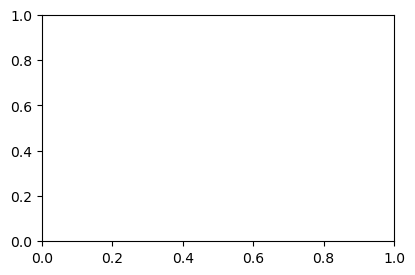